In [1]:
from explauto.environment import environments
environments.keys()

dict_keys(['simple_arm', 'pendulum', 'npendulum'])

In [2]:
from explauto.environment import available_configurations
available_configurations('simple_arm').keys()

dict_keys(['mid_dimensional', 'low_dimensional', 'default', 'high_dim_high_s_range', 'high_dimensional'])

In [3]:
available_configurations('simple_arm')['mid_dimensional']

{'length_ratio': 1.5,
 'm_maxs': array([ 1.04719755,  1.04719755,  1.04719755,  1.04719755,  1.04719755,
         1.04719755,  1.04719755]),
 'm_mins': array([-1.04719755, -1.04719755, -1.04719755, -1.04719755, -1.04719755,
        -1.04719755, -1.04719755]),
 'noise': 0.02,
 's_maxs': array([ 1.,  1.]),
 's_mins': array([-0.5, -1. ])}

In [4]:
available_configurations('pendulum').keys()

dict_keys(['underactuated', 'default'])

In [5]:
from explauto import Environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

In [6]:
from numpy import pi
m = [-pi/6., pi/3., pi/4., pi/5., 0., pi/3., pi/6.]
environment.compute_sensori_effect(m)

array([ 0.38737322,  0.24700429])

Populating the interactive namespace from numpy and matplotlib


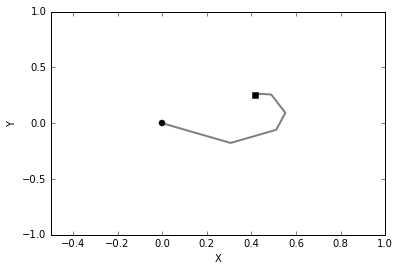

In [7]:
# Create the axes for plotting::
%pylab inline
ax = axes()

# plot the arm:
environment.plot_arm(ax, m)

In [8]:
motor_configurations = environment.random_motors(n=10)

Populating the interactive namespace from numpy and matplotlib


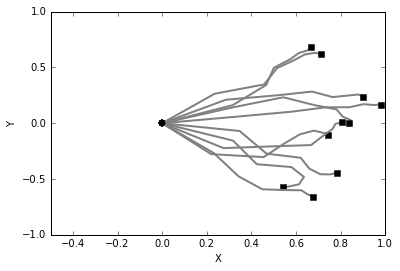

In [9]:
# Create the axes for plotting::
%pylab inline
ax = axes()

# Plotting 10 random motor configurations:
for m in motor_configurations:
    environment.plot_arm(ax, m)

In [10]:
environment = Environment.from_configuration('pendulum', 'default')

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


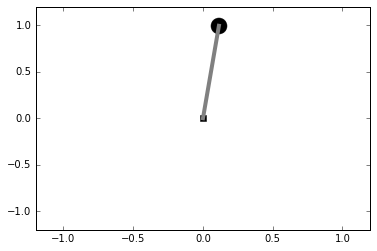

In [11]:
%pylab
ax = axes()

# Sequence of torques at each time step:
U = [0.25] * 15 + [-0.25] * 15 + [0.25] * 19

# reset to lower position:
environment.reset() 

# apply torque and plot:
for u in U:
    ax.cla()
    environment.apply_torque(u)
    environment.plot_current_state(ax)
    draw()

In [12]:
environment.compute_sensori_effect(environment.random_motors())

array([-2.72988673, -1.78396521])

In [13]:
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

In [14]:
from explauto.sensorimotor_model import sensorimotor_models
sensorimotor_models.keys()

dict_keys(['nearest_neighbor', 'WNN', 'LWLR-BFGS', 'LWLR-CMAES'])

In [15]:
from explauto.sensorimotor_model import available_configurations
available_configurations('nearest_neighbor')

{'default': {'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio': 0.1},
 'exact': {'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio': 0.0}}

In [16]:
from explauto import SensorimotorModel
sm_model = SensorimotorModel.from_configuration(environment.conf, 'nearest_neighbor', 'exact')

In [17]:
for m in environment.random_motors(n=1000):
    # compute the sensori effect s of the motor command m through the environment:
    s = environment.compute_sensori_effect(m)
    # update the model according to this experience:
    sm_model.update(m, s)

In [18]:
# random motor command:
m = environment.random_motors(n=1)[0]
# predicted sensory effect:
s_pred = sm_model.forward_prediction(m)

print('random motor command: ', m)
print('predicted effect: ', s_pred)

random motor command:  [ 0.22352046 -0.54288479 -0.13610877  0.21393084 -0.56963832  0.11808048
  0.44711696]
predicted effect:  [ 0.79365554 -0.33427329]


Populating the interactive namespace from numpy and matplotlib


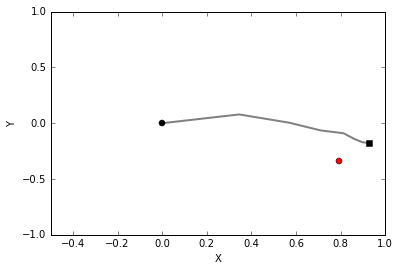

In [19]:
%pylab inline
ax = axes()

environment.plot_arm(ax, m)
ax.plot(*s_pred, marker='o', color='red')

In [20]:
s_g = [0.7, 0.5]
m = sm_model.inverse_prediction(s_g)
print('Inferred motor command to reach the position ', s_g, ': ', m)

Inferred motor command to reach the position  [0.7, 0.5] :  [ 0.43292164 -0.43434841  0.88199599  0.58556165 -0.25727236 -0.18203199
  0.73802972]


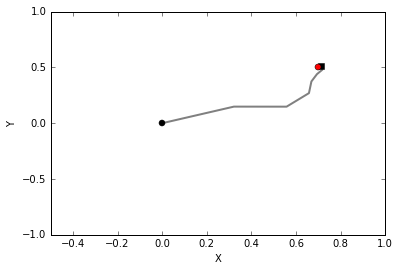

In [21]:
ax = axes()
environment.plot_arm(ax, m)
ax.plot(*s_g, marker='o', color='red')

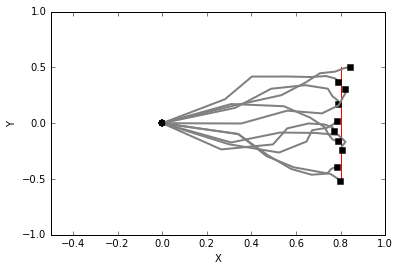

In [22]:
ax = axes()

# Define the line and plot it:
x = 0.8
y_a = 0.5
y_b = -0.5
ax.plot([x, x], [y_a, y_b], color='red')

# for 10 points equidistantly spaced on the line, perform inverse prediction and plot:
for y in linspace(-0.5, 0.5, 10):
    m = sm_model.inverse_prediction([x, y])
    environment.plot_arm(ax, m)

In [23]:
sm_model = SensorimotorModel.from_configuration(environment.conf, 'LWLR-BFGS', 'default')

In [24]:
from explauto.interest_model import interest_models, available_configurations
interest_models.keys()

dict_keys(['discretized_progress', 'gmm_progress_beta', 'tree', 'random'])

In [25]:
available_configurations('discretized_progress')

{'default': {'measure': <function explauto.interest_model.competences.competence_dist>,
  'win_size': 10,
  'x_card': 400}}

In [26]:
from explauto import InterestModel
im_model = InterestModel.from_configuration(environment.conf, environment.conf.m_dims, 'random')

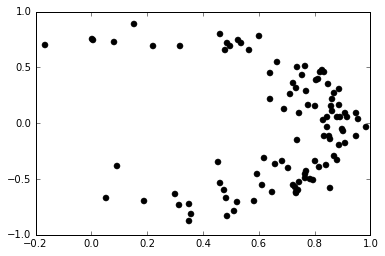

In [27]:
# re-instantiate the sensorimotor model (to forget what was previously learnt in the previous section
sm_model = SensorimotorModel.from_configuration(environment.conf, 'nearest_neighbor', 'default')

# run the simulation loop
for _ in range(100):
    # sample a random motor command using the interest model:
    m = im_model.sample()
    # execute this command and observe the corresponding sensory effect:
    s = environment.compute_sensori_effect(m)
    # update the sensorimotor model:
    sm_model.update(m, s)
    im_model.update(hstack((m, s)), hstack((m, s_g)))
    # plot the observed sensory effect:
    plot(s[0], s[1], 'ok')

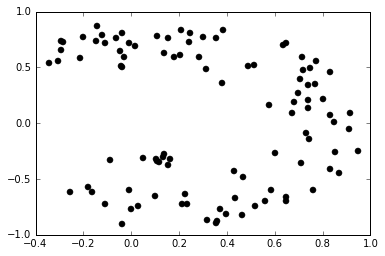

In [28]:
# Instantiate a random goal interest model:
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'random')

for _ in range(100):
    # sample a random sensory goal using the interest model:
    s_g = im_model.sample()
    # infer a motor command to reach that goal using the sensorimotor model:
    m = sm_model.inverse_prediction(s_g)
    # execute this command and observe the corresponding sensory effect:
    s = environment.compute_sensori_effect(m)
    # update the sensorimotor model:
    sm_model.update(m, s)
    # plot the observed sensory effect:
    plot(s[0], s[1], 'ok')

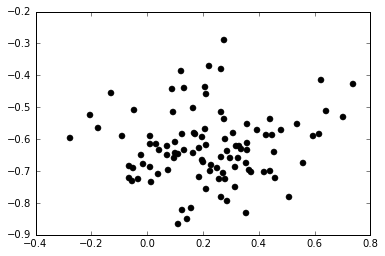

In [29]:
# Instantiate an active goal interest model:
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'discretized_progress')

for _ in range(100):
    # sample a sensory goal maximizing learning progress using the interest model:
    s_g = im_model.sample()
    # infer a motor command to reach that goal using the sensorimotor model:
    m = sm_model.inverse_prediction(s_g)
    # execute this command and observe the corresponding sensory effect:
    s = environment.compute_sensori_effect(m)
    # update the sensorimotor model:
    sm_model.update(m, s)
    # update the interest model:
    im_model.update(hstack((m, s)), hstack((m, s_g)))
    # plot the observed sensory effect:
    plot(s[0], s[1], 'ok')

In [30]:
from explauto import Agent

sm_model = SensorimotorModel.from_configuration(environment.conf, 'nearest_neighbor', 'default')
im_model = InterestModel.from_configuration(environment.conf, environment.conf.m_dims, 'random')

agent = Agent(environment.conf, sm_model, im_model)

In [31]:
m = agent.produce()
print(m)

[-0.27914823 -0.14268     0.10718381  0.67353188  0.75987896  0.76739288
  0.3308952 ]


In [32]:
s = environment.update(m)
agent.perceive(s)

In [33]:
for _ in range(100):
    m = agent.produce()
    s = environment.update(m)
    agent.perceive(s)    

In [34]:
sm_model = SensorimotorModel.from_configuration(environment.conf, 'nearest_neighbor', 'default')
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'discretized_progress')

agent = Agent(environment.conf, sm_model, im_model)

In [35]:
for _ in range(100):
    m = agent.produce()
    s = environment.update(m)
    agent.perceive(s)

In [36]:
from explauto import Experiment

expe = Experiment(environment, agent)

In [37]:
from explauto.experiment import make_settings

random_goal_babbling = make_settings(environment='simple_arm', environment_config = 'mid_dimensional',
                                     babbling_mode='goal', 
                                     interest_model='random',
                                     sensorimotor_model='nearest_neighbor')

expe = Experiment.from_settings(random_goal_babbling)

In [38]:
expe.evaluate_at([100, 200, 400, 1000], random_goal_babbling.default_testcases)

In [39]:
expe.run()

Populating the interactive namespace from numpy and matplotlib


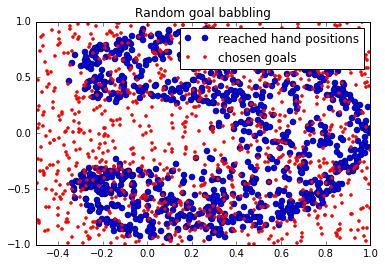

In [40]:
%pylab inline
ax = axes()
title(('Random goal babbling'))

expe.log.scatter_plot(ax, (('sensori', [0, 1]),))
expe.log.scatter_plot(ax, (('choice', [0, 1]),), marker='.', color='red')
#expe.log.scatter_plot(ax, (('testcases', [0, 1]),), marker='o', color='green')

legend(['reached hand positions', 'chosen goals'])

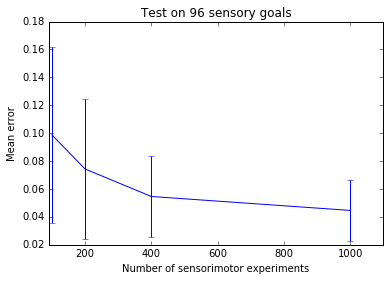

In [41]:
ax = axes()
expe.log.plot_learning_curve(ax)

In [42]:
from explauto import ExperimentPool
xps = ExperimentPool.from_settings_product(environments=[('simple_arm', 'high_dim_high_s_range')],
                                           babblings=['goal'],
                                           interest_models=[('random', 'default'), ('discretized_progress', 'default')],
                                           sensorimotor_models=[('nearest_neighbor', 'default')],
                                           evaluate_at=[200, 500, 900, 1400],
                                           same_testcases=True)

In [43]:
xps.run()

array([[<explauto.experiment.log.ExperimentLog object at 0x000000A9AEE7F6D8>],
       [<explauto.experiment.log.ExperimentLog object at 0x000000A9AEE401D0>]], dtype=object)

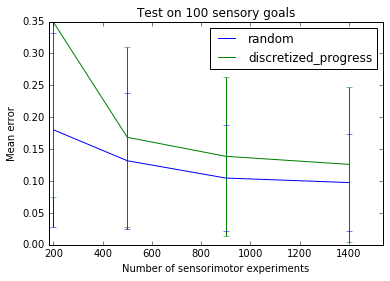

In [44]:
ax = axes()

for log in xps.logs:
    log.plot_learning_curve(ax)
    
legend([s.interest_model for s in xps.settings])

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


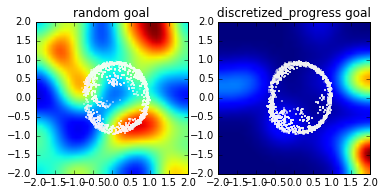

In [45]:
%pylab
clf()
last_t = 0
for t in linspace(100, xps.logs[0].eval_at[-1], 40):
    t = int(t)
    for i, (config, log) in enumerate(zip(xps.settings, xps.logs)):
        ax = subplot(1, 2, i+1)
        log.scatter_plot(ax, (('sensori', [0, 1]),), range(0, t), marker='.', markersize=0.3, color = 'white')
        log.density_plot(ax, (('choice', [0, 1]),), range(last_t, t))
        title(config.interest_model + ' ' + config.babbling_mode)
        draw()
    last_t = t
